In [1]:
import os
from typing import List
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import Model
from keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, Input, BatchNormalization
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.activations import relu

# Для получения доступа к изображениям импортируем метод
from keras.preprocessing import image_dataset_from_directory as datagen

# Для получения оne-hot еncoding представления меток классов импортируем метод
from keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Функция для подсчета метрик и создния матрицы ошибок
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_metrics_plot_confusion_matrix(classes, y_test, y_pred, cls_name):
  print(cls_name)
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.show()

# Подготовка изображений

Из наборов изображений, которые полученные в лабораторной работе № 11, выбрать по 135 изображений каждой цифры без шума: 100/15/20 для обучающей/валидационной/тестовой выборок. В каждой выборке должно содержаться равное количество изображений каждой цифры в вертикальном и горизонтальном положении соответственно.

In [4]:
HOME_DIR = '/content/drive/MyDrive/ForColab/train_images/'

In [5]:
!ls '/content/drive/MyDrive/ForColab/train_images/'

model_tl.weights.h5  test_images3.npy  train_images100.npy  train_images600.npy
test_images1.npy     test_images4.npy  train_images200.npy  train_images.npy
test_images2.npy     test_images5.npy  train_images400.npy


In [6]:
train_images = np.load(HOME_DIR + 'train_images.npy').reshape(-1, 100, 100, 1)
test_images = np.load(HOME_DIR + 'test_images1.npy').reshape(-1, 100, 100, 1)

In [7]:
def generate_dataset(data: np.ndarray):
  used_classes = np.array([0, 1, 3, 8])
  dataset = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in data])
  dataset = dataset.astype('float32') / 255.0
  labels = [i for i in used_classes for _ in range(dataset.shape[0] // len(used_classes))]
  labels = to_categorical(labels, 10)

  return dataset, labels

In [8]:
def prepare_data(train_len: int, val_len: int, dataset: np.ndarray, classes_count: int):
  class_size = dataset.shape[0] // classes_count
  updated_dataset = []
  train_data = []
  val_data = []

  for i in range(classes_count):
    for j in range(train_len):
      train_data.append(dataset[i * class_size + j])

    for j in range(val_len):
      val_data.append(dataset[i * class_size + j])

  train_data = np.array(train_data)
  val_data = np.array(val_data)

  train_rgb, train_labels_ohe = generate_dataset(train_data)
  val_rgb, val_labels_ohe = generate_dataset(val_data)

  return train_rgb, train_labels_ohe, val_rgb, val_labels_ohe

In [9]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(100, 15, train_images, 4)
test_rgb, test_labels_ohe = generate_dataset(test_images)

# Загрузка моделей

Используя torch по очереди каждую из сверточных нейронных сетей: Xception, ResNet152V2, InceptionResNetV2, DenseNet201, NASNetLarge дообучить сеть на этих картинках и вывести результаты классификации на тестовом множестве.


In [10]:
width = height = 100

In [11]:
xception_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(width, height, 3))
resnet152v2_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(width, height, 3))
inceptionresnetv2_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(width, height, 3))
densenet201_model = keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(width, height, 3))
nasnetlarge_model = keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(width, height, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Чтобы сверточная часть не обучалась в процессе дообучения задаем:

In [12]:
for layer in xception_model.layers:
  layer.trainable = False

for layer in resnet152v2_model.layers:
  layer.trainable = False

for layer in inceptionresnetv2_model.layers:
  layer.trainable = False

for layer in densenet201_model.layers:
  layer.trainable = False

for layer in nasnetlarge_model.layers:
  layer.trainable = False

# Обучение и тестирование моделей

Создаем модель, в которой добавляем полносвязную часть:

In [13]:
def get_model(pretrained_model):
    model = Sequential()

    model.add(Input(shape=(width, height, 3)))
    model.add(pretrained_model)  # Добавили предобученную CNN
    model.add(Flatten())  # Матрицу изображения преобразовали в одномерный вектор
    model.add(Dense(128, activation='relu'))  # Полносвязный слой с функцией активации
    model.add(Dropout(0.5))  # Слой Dropout для снижения переобучения
    model.add(Dense(10, activation='softmax'))   # Полносвязный слой с функцией активации
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

### Xception model

#### 100 + 15 + 20

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(xception_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5656 - loss: 1.3669
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - accuracy: 0.5733 - loss: 1.3446 - val_accuracy: 0.9500 - val_loss: 0.2281
Epoch 2/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8977 - loss: 0.3021
Epoch 2: val_accuracy improved from 0.95000 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8982 - loss: 0.2995 - val_accuracy: 1.0000 - val_loss: 0.1054
Epoch 3/500
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9597 - loss: 0.1606
Epoch 3: val_accuracy did not improve from 1.00000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9581 - loss: 0.1624 - val_accuracy: 1.0000 - val_loss: 0.0720
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9557

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.90      0.95      0.93        20
           8       0.95      0.90      0.92        20

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



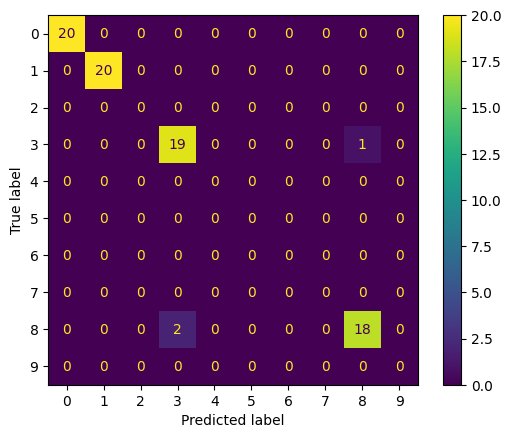

Test loss value: 0.228907
Test accuracy: 0.962500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 250 + 30 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(250, 30, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(xception_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6624 - loss: 1.0832
Epoch 1: val_accuracy improved from -inf to 0.96667, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.6706 - loss: 1.0571 - val_accuracy: 0.9667 - val_loss: 0.1327
Epoch 2/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9376 - loss: 0.2368
Epoch 2: val_accuracy improved from 0.96667 to 0.99167, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9379 - loss: 0.2349 - val_accuracy: 0.9917 - val_loss: 0.0559
Epoch 3/500
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9648 - loss: 0.1369
Epoch 3: val_accuracy improved from 0.99167 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9647 - loss: 0.1356 - val_accuracy: 1.0000 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      0.95      0.97        20
           8       0.95      1.00      0.98        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



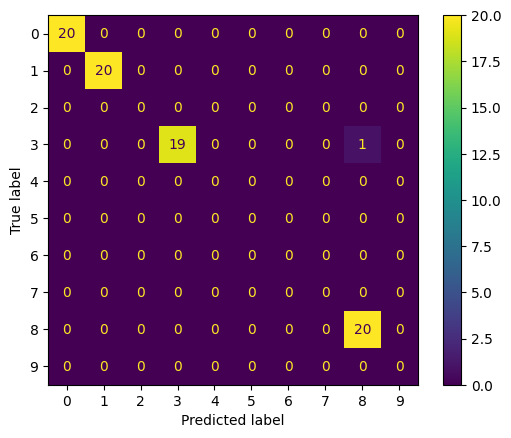

Test loss value: 0.128724
Test accuracy: 0.987500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 400 + 60 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(400, 60, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(xception_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7786 - loss: 0.6953
Epoch 1: val_accuracy improved from -inf to 0.98333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.7820 - loss: 0.6843 - val_accuracy: 0.9833 - val_loss: 0.0744
Epoch 2/500
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9524 - loss: 0.1454
Epoch 2: val_accuracy improved from 0.98333 to 0.99583, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9526 - loss: 0.1451 - val_accuracy: 0.9958 - val_loss: 0.0358
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9691 - loss: 0.0863
Epoch 3: val_accuracy improved from 0.99583 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9691 - loss: 0.0862 - val_accuracy: 1.0000 - va

1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      0.95      0.97        20
           8       0.95      1.00      0.98        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



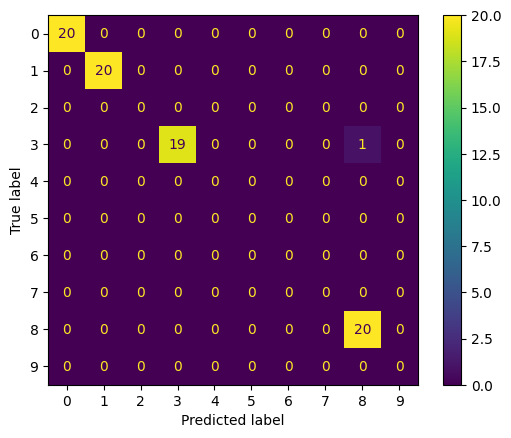

Test loss value: 0.063247
Test accuracy: 0.987500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 700 + 100 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(700, 100, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(xception_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
138/140 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7899 - loss: 0.6313
Epoch 1: val_accuracy improved from -inf to 0.99000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7921 - loss: 0.6250 - val_accuracy: 0.9900 - val_loss: 0.0531
Epoch 2/500
138/140 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9639 - loss: 0.1098
Epoch 2: val_accuracy improved from 0.99000 to 0.99250, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9640 - loss: 0.1095 - val_accuracy: 0.9925 - val_loss: 0.0411
Epoch 3/500
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9824 - loss: 0.0676
Epoch 3: val_accuracy did not improve from 0.99250
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9823 - loss: 0.0676 - val_accuracy: 0.9925 - val_loss: 0.0252
Epoch 4/500
138/140 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - ac

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



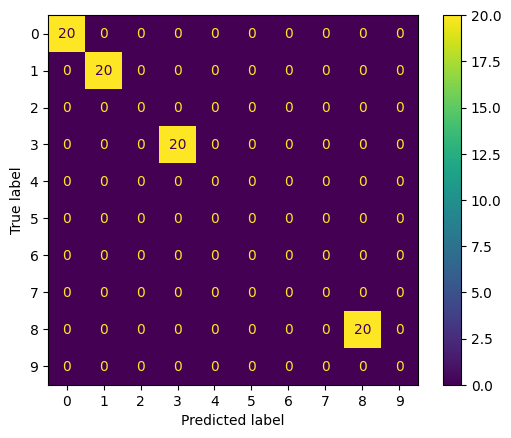

Test loss value: 0.001262
Test accuracy: 1.000000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

### ResNet152V2

#### 100 + 15 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(100, 15, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(resnet152v2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5482 - loss: 2.3242
Epoch 1: val_accuracy improved from -inf to 0.91667, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 712ms/step - accuracy: 0.5638 - loss: 2.2656 - val_accuracy: 0.9167 - val_loss: 0.2529
Epoch 2/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8547 - loss: 0.7557
Epoch 2: val_accuracy improved from 0.91667 to 0.96667, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8562 - loss: 0.7528 - val_accuracy: 0.9667 - val_loss: 0.1049
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9121 - loss: 0.4507
Epoch 3: val_accuracy improved from 0.96667 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9123 - loss: 0.4495 - val_accuracy: 1.0000 

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        20
           3       0.76      0.95      0.84        20
           8       0.93      0.65      0.76        20

    accuracy                           0.90        80
   macro avg       0.91      0.90      0.90        80
weighted avg       0.91      0.90      0.90        80



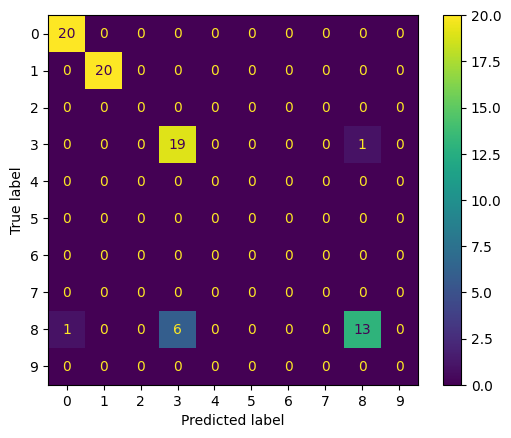

Test loss value: 0.288132
Test accuracy: 0.900000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 250 + 30 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(250, 30, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(resnet152v2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6593 - loss: 1.6433
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 432ms/step - accuracy: 0.6616 - loss: 1.6327 - val_accuracy: 0.9000 - val_loss: 0.2971
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8528 - loss: 0.4522
Epoch 2: val_accuracy improved from 0.90000 to 0.98333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.8532 - loss: 0.4506 - val_accuracy: 0.9833 - val_loss: 0.0636
Epoch 3/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9134 - loss: 0.1905
Epoch 3: val_accuracy did not improve from 0.98333
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9133 - loss: 0.1910 - val_accuracy: 0.9583 - val_loss: 0.0754
Epoch 4/500
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.904

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.91      1.00      0.95        20
           8       1.00      0.90      0.95        20

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



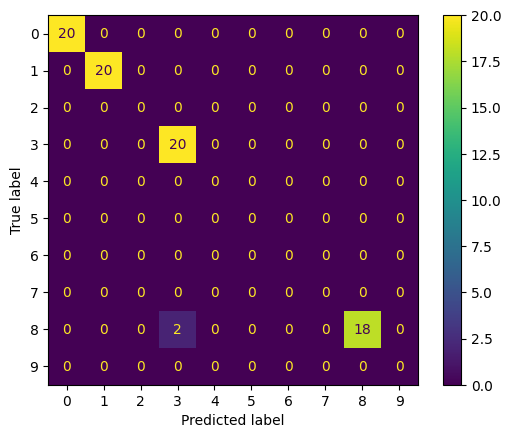

Test loss value: 0.057409
Test accuracy: 0.975000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 400 + 60 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(400, 60, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(resnet152v2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7111 - loss: 1.5291
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 55s 270ms/step - accuracy: 0.7136 - loss: 1.5123 - val_accuracy: 0.9500 - val_loss: 0.1109
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9006 - loss: 0.2995
Epoch 2: val_accuracy did not improve from 0.95000
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9008 - loss: 0.2991 - val_accuracy: 0.9250 - val_loss: 0.1466
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9130 - loss: 0.2476
Epoch 3: val_accuracy improved from 0.95000 to 0.97500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9132 - loss: 0.2470 - val_accuracy: 0.9750 - val_loss: 0.0470
Epoch 4/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.933

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      1.00      1.00        20
           3       0.91      1.00      0.95        20
           8       1.00      0.80      0.89        20

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



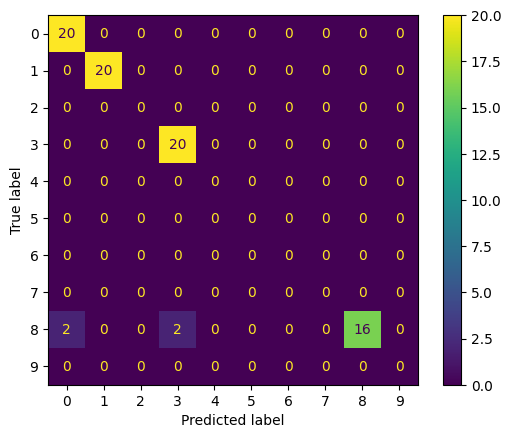

Test loss value: 0.463493
Test accuracy: 0.950000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 700 + 100 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(700, 100, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(resnet152v2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7892 - loss: 1.3655
Epoch 1: val_accuracy improved from -inf to 0.93500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.7897 - loss: 1.3611 - val_accuracy: 0.9350 - val_loss: 0.1367
Epoch 2/500
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9282 - loss: 0.2123
Epoch 2: val_accuracy improved from 0.93500 to 0.95500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.9282 - loss: 0.2122 - val_accuracy: 0.9550 - val_loss: 0.0906
Epoch 3/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9369 - loss: 0.1624
Epoch 3: val_accuracy improved from 0.95500 to 0.97500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9369 - loss: 0.1624 - val_accur

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.95      1.00      0.98        20
           8       1.00      0.95      0.97        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



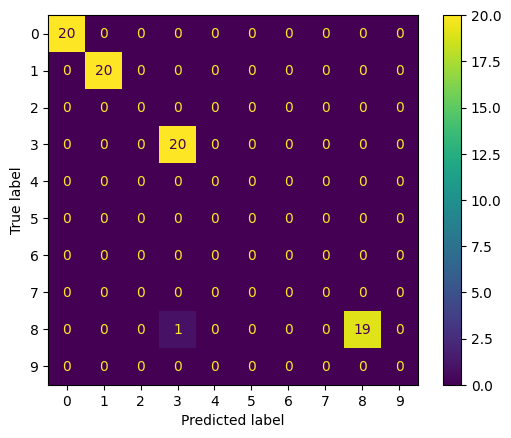

Test loss value: 0.045311
Test accuracy: 0.987500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

### InceptionResNetV2

#### 100 + 15 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(100, 15, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(inceptionresnetv2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4089 - loss: 1.6928
Epoch 1: val_accuracy improved from -inf to 0.78333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4161 - loss: 1.6774 - val_accuracy: 0.7833 - val_loss: 0.8060
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7175 - loss: 0.9117
Epoch 2: val_accuracy improved from 0.78333 to 0.90000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.7191 - loss: 0.9082 - val_accuracy: 0.9000 - val_loss: 0.5655
Epoch 3/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7950 - loss: 0.6574
Epoch 3: val_accuracy did not improve from 0.90000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7936 - loss: 0.6584 - val_accuracy: 0.9000 - val_loss: 0.5166
Epoch 4/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7893 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       1.00      0.90      0.95        20
           3       0.71      1.00      0.83        20
           8       0.87      0.65      0.74        20

    accuracy                           0.86        80
   macro avg       0.88      0.86      0.86        80
weighted avg       0.88      0.86      0.86        80



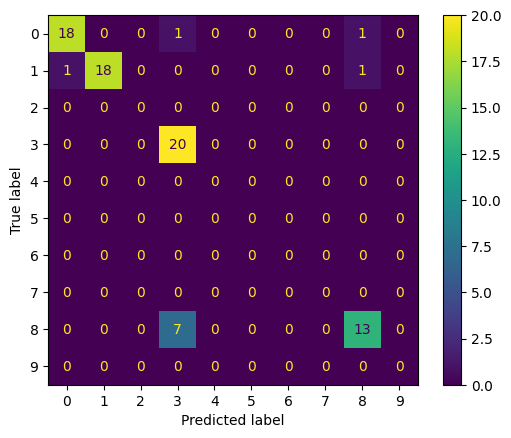

Test loss value: 0.411406
Test accuracy: 0.862500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 250 + 30 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(200, 30, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(inceptionresnetv2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4890 - loss: 1.4744
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 863ms/step - accuracy: 0.4965 - loss: 1.4547 - val_accuracy: 0.8333 - val_loss: 0.6042
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7598 - loss: 0.6667
Epoch 2: val_accuracy improved from 0.83333 to 0.86667, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 796ms/step - accuracy: 0.7607 - loss: 0.6647 - val_accuracy: 0.8667 - val_loss: 0.4398
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8027 - loss: 0.4899
Epoch 3: val_accuracy improved from 0.86667 to 0.88333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.8031 - loss: 0.4891 - val_accuracy: 0.8833

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.95      0.90      0.92        20
           3       0.68      0.85      0.76        20
           8       0.78      0.70      0.74        20

    accuracy                           0.82        80
   macro avg       0.84      0.82      0.83        80
weighted avg       0.84      0.82      0.83        80



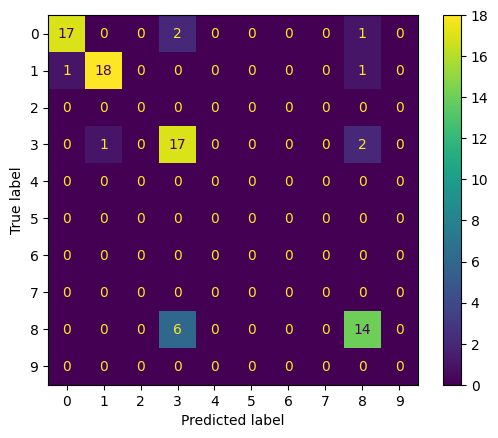

Test loss value: 0.346324
Test accuracy: 0.825000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 400 + 60 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(400, 60, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(inceptionresnetv2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5811 - loss: 1.3184
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5839 - loss: 1.3079 - val_accuracy: 0.8250 - val_loss: 0.5048
Epoch 2/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7947 - loss: 0.5184
Epoch 2: val_accuracy improved from 0.82500 to 0.84167, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 520ms/step - accuracy: 0.7950 - loss: 0.5175 - val_accuracy: 0.8417 - val_loss: 0.4227
Epoch 3/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8201 - loss: 0.4443
Epoch 3: val_accuracy improved from 0.84167 to 0.87083, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 111s 892ms/step - accuracy: 0.8205 - loss: 0.4433 - val_accuracy: 0.8708 

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.95      0.90      0.92        20
           3       0.90      0.95      0.93        20
           8       0.86      0.90      0.88        20

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80



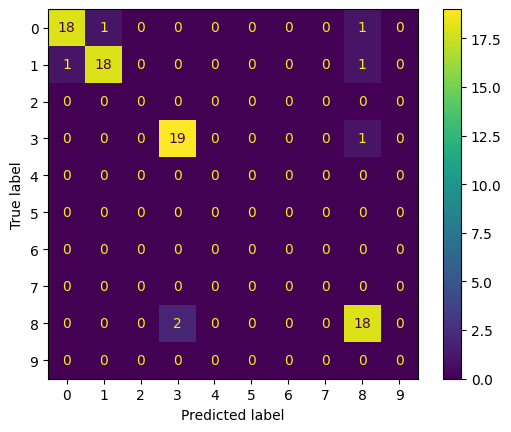

Test loss value: 0.367921
Test accuracy: 0.912500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 700 + 100 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(700, 100, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(inceptionresnetv2_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6539 - loss: 1.0516
Epoch 1: val_accuracy improved from -inf to 0.86250, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 63s 187ms/step - accuracy: 0.6553 - loss: 1.0467 - val_accuracy: 0.8625 - val_loss: 0.4167
Epoch 2/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8349 - loss: 0.4121
Epoch 2: val_accuracy improved from 0.86250 to 0.86750, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8349 - loss: 0.4120 - val_accuracy: 0.8675 - val_loss: 0.3372
Epoch 3/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8334 - loss: 0.3754
Epoch 3: val_accuracy did not improve from 0.86750
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8336 - loss: 0.3752 - val_accuracy: 0.8500 - val_loss: 0.3106
Epoch 4/500
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - a

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.90      0.95      0.93        20
           3       0.95      1.00      0.98        20
           8       0.95      0.90      0.92        20

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



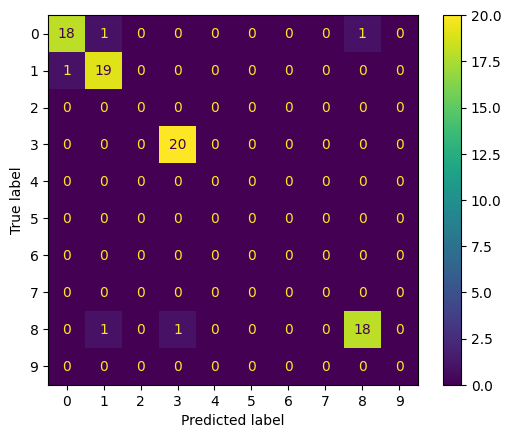

Test loss value: 0.179491
Test accuracy: 0.937500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

### DenseNet201

#### 100 + 15 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(100, 15, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(densenet201_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5364 - loss: 1.4845
Epoch 1: val_accuracy improved from -inf to 0.96667, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5443 - loss: 1.4558 - val_accuracy: 0.9667 - val_loss: 0.0928
Epoch 2/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8796 - loss: 0.3093
Epoch 2: val_accuracy did not improve from 0.96667
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8823 - loss: 0.3015 - val_accuracy: 0.9667 - val_loss: 0.0793
Epoch 3/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9504 - loss: 0.1145
Epoch 3: val_accuracy improved from 0.96667 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9513 - loss: 0.1132 - val_accuracy: 1.0000 - val_loss: 0.0229
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9633 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      1.00      1.00        20
           3       0.95      1.00      0.98        20
           8       1.00      1.00      1.00        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



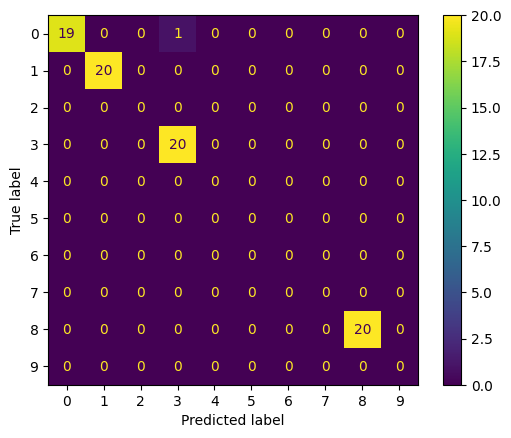

Test loss value: 0.037614
Test accuracy: 0.987500


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 250 + 30 + 20

In [ ]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(250, 30, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(densenet201_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6267 - loss: 1.1493
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 666ms/step - accuracy: 0.6298 - loss: 1.1384 - val_accuracy: 0.9750 - val_loss: 0.0750
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9326 - loss: 0.1725
Epoch 2: val_accuracy improved from 0.97500 to 0.98333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - accuracy: 0.9328 - loss: 0.1719 - val_accuracy: 0.9833 - val_loss: 0.0397
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9626 - loss: 0.0898
Epoch 3: val_accuracy improved from 0.98333 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9627 - loss: 0.0897 - val_accuracy: 1.0000 -

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



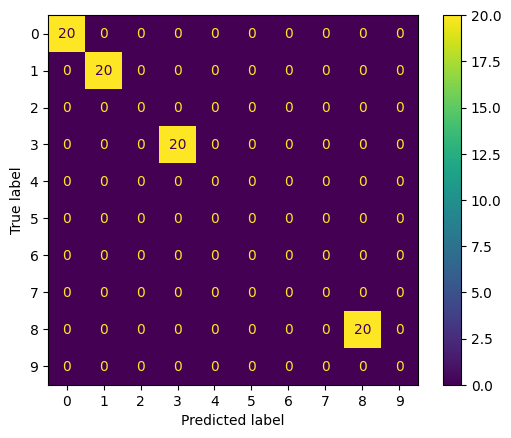

Test loss value: 0.001479
Test accuracy: 1.000000


In [ ]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 400 + 60 + 20

In [13]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(400, 60, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(densenet201_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7286 - loss: 0.9107
Epoch 1: val_accuracy improved from -inf to 0.99583, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.7317 - loss: 0.8992 - val_accuracy: 0.9958 - val_loss: 0.0304
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9550 - loss: 0.1147
Epoch 2: val_accuracy did not improve from 0.99583
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.9551 - loss: 0.1145 - val_accuracy: 0.9917 - val_loss: 0.0237
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.0736
Epoch 3: val_accuracy improved from 0.99583 to 1.00000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9689 - loss: 0.0735 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 4/500
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.987

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



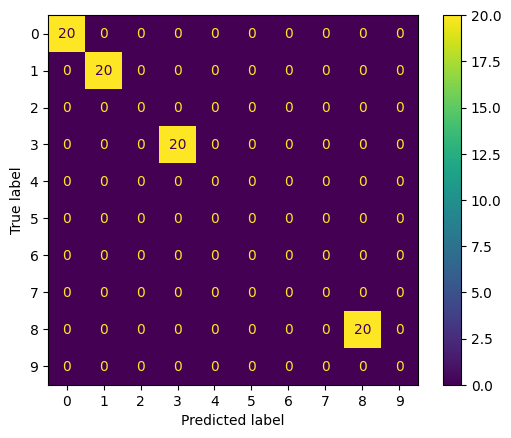

Test loss value: 0.001943
Test accuracy: 1.000000


In [14]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 700 + 100 + 20

In [15]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(700, 100, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(densenet201_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8155 - loss: 0.5376
Epoch 1: val_accuracy improved from -inf to 0.98500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - accuracy: 0.8162 - loss: 0.5355 - val_accuracy: 0.9850 - val_loss: 0.0327
Epoch 2/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9818 - loss: 0.0606
Epoch 2: val_accuracy improved from 0.98500 to 0.99500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.9818 - loss: 0.0606 - val_accuracy: 0.9950 - val_loss: 0.0279
Epoch 3/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9785 - loss: 0.0574
Epoch 3: val_accuracy did not improve from 0.99500
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9785 - loss: 0.0573 - val_accuracy: 0.9825 - val_loss: 0.0511
Epoch 4/500
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - a

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



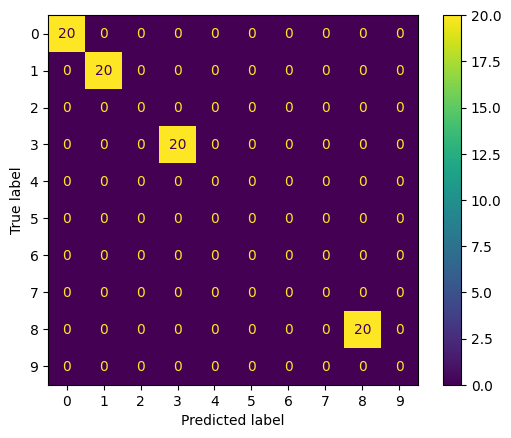

Test loss value: 0.004702
Test accuracy: 1.000000


In [16]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

### NASNetLarge

#### 100 + 15 + 20

In [17]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(100, 15, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(nasnetlarge_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5245 - loss: 1.4320
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5305 - loss: 1.4117 - val_accuracy: 0.9333 - val_loss: 0.2375
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8499 - loss: 0.3534
Epoch 2: val_accuracy improved from 0.93333 to 0.95000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 830ms/step - accuracy: 0.8517 - loss: 0.3520 - val_accuracy: 0.9500 - val_loss: 0.1310
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8925 - loss: 0.2734
Epoch 3: val_accuracy improved from 0.95000 to 0.98333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.8935 - loss: 0.2718 - val_accuracy: 0.9833 - 

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step
Pretrained model
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      1.00      1.00        20
           3       0.61      0.85      0.71        20
           8       0.82      0.45      0.58        20

    accuracy                           0.81        80
   macro avg       0.83      0.81      0.80        80
weighted avg       0.83      0.81      0.80        80



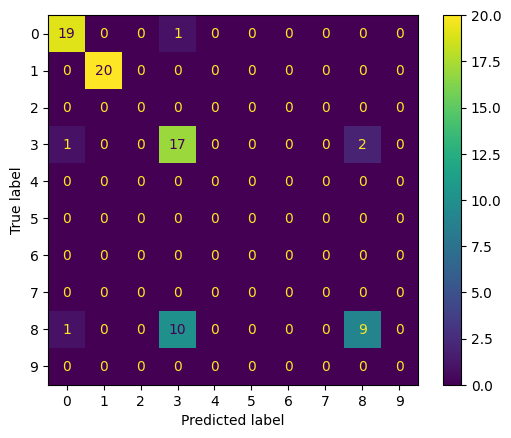

Test loss value: 0.830040
Test accuracy: 0.812500


In [18]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 250 + 30 + 20

In [19]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(250, 30, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(nasnetlarge_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6385 - loss: 1.0364
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 0.6410 - loss: 1.0288 - val_accuracy: 0.9750 - val_loss: 0.1534
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9116 - loss: 0.2368
Epoch 2: val_accuracy did not improve from 0.97500
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9117 - loss: 0.2367 - val_accuracy: 0.9750 - val_loss: 0.0836
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9448 - loss: 0.1533
Epoch 3: val_accuracy improved from 0.97500 to 0.98333, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.9449 - loss: 0.1528 - val_accuracy: 0.9833 - val_loss: 0.0497
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9

3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.95      1.00      0.98        20
           8       1.00      0.95      0.97        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



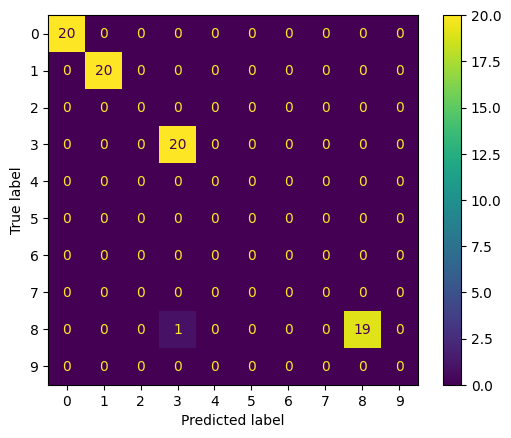

Test loss value: 0.050333
Test accuracy: 0.987500


In [20]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 400 + 60 + 20

In [21]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(400, 60, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(nasnetlarge_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6654 - loss: 0.8588
Epoch 1: val_accuracy improved from -inf to 0.95417, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6672 - loss: 0.8544 - val_accuracy: 0.9542 - val_loss: 0.1605
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9500 - loss: 0.1748
Epoch 2: val_accuracy improved from 0.95417 to 0.96250, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9500 - loss: 0.1747 - val_accuracy: 0.9625 - val_loss: 0.1021
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9534 - loss: 0.1323
Epoch 3: val_accuracy improved from 0.96250 to 0.98750, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9535 - loss: 0.1322 - val_accuracy: 0.9875 - val

3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.95      1.00      0.98        20
           8       1.00      0.95      0.97        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



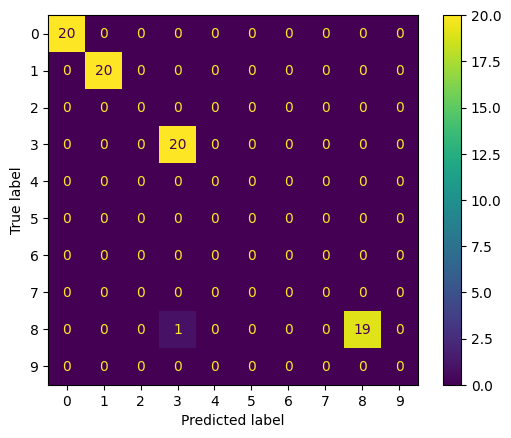

Test loss value: 0.043730
Test accuracy: 0.987500


In [22]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

#### 700 + 100 + 20

In [14]:
train_rgb, train_labels_ohe, val_rgb, val_labels_ohe = prepare_data(700, 100, train_images, 4)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights = False)

checkpoint = keras.callbacks.ModelCheckpoint(HOME_DIR + r"model_tl.weights.h5",# path + r"/model_tl.model.keras",
                    monitor='val_accuracy', mode="max",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1)

model = get_model(nasnetlarge_model)

history = model.fit(train_rgb,
                    train_labels_ohe,
                    shuffle=True,
                    callbacks=[early_stop, checkpoint],
                    validation_data=(val_rgb, val_labels_ohe),
                    epochs=500,
                    batch_size=20)

Epoch 1/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7348 - loss: 0.6989
Epoch 1: val_accuracy improved from -inf to 0.95250, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 326ms/step - accuracy: 0.7356 - loss: 0.6967 - val_accuracy: 0.9525 - val_loss: 0.1356
Epoch 2/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9550 - loss: 0.1397
Epoch 2: val_accuracy improved from 0.95250 to 0.97000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.9550 - loss: 0.1396 - val_accuracy: 0.9700 - val_loss: 0.0776
Epoch 3/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9612 - loss: 0.0998
Epoch 3: val_accuracy improved from 0.97000 to 0.98000, saving model to /content/drive/MyDrive/ForColab/train_images/model_tl.weights.h5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.9612 - loss: 0.0997 - val_accu

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step
Pretrained model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           3       0.95      0.95      0.95        20
           8       0.95      0.95      0.95        20

    accuracy                           0.97        80
   macro avg       0.98      0.98      0.98        80
weighted avg       0.97      0.97      0.97        80



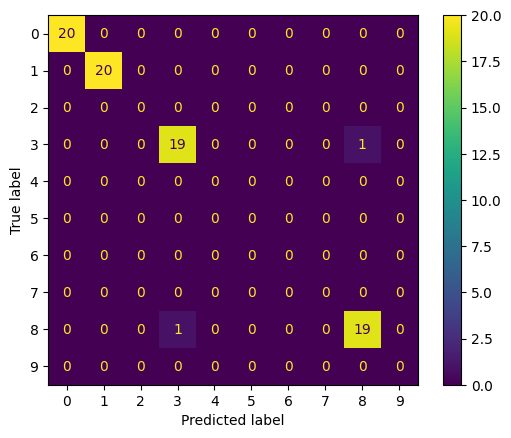

Test loss value: 0.090015
Test accuracy: 0.975000


In [15]:
y_pred = model.predict(test_rgb).argmax(axis=1)
y_test = np.argmax(test_labels_ohe, axis=1)
get_metrics_plot_confusion_matrix([i for i in range(10)], y_test, y_pred, 'Pretrained model')

score = model.evaluate(test_rgb, test_labels_ohe, verbose=0)
print("Test loss value: %f" % score[0])
print("Test accuracy: %f" % score[1])

# Полученные результаты оформить в виде таблицы со столбцами: название сети, размеры выборок, матрица ошибок (confusion matrix), метрики: точность (precision), полнота (recall), f1-метрика. Выбрать и зафиксировать для следующей лабораторной работы 3 сети, которые обеспечивают набольшее значение метрики f1.

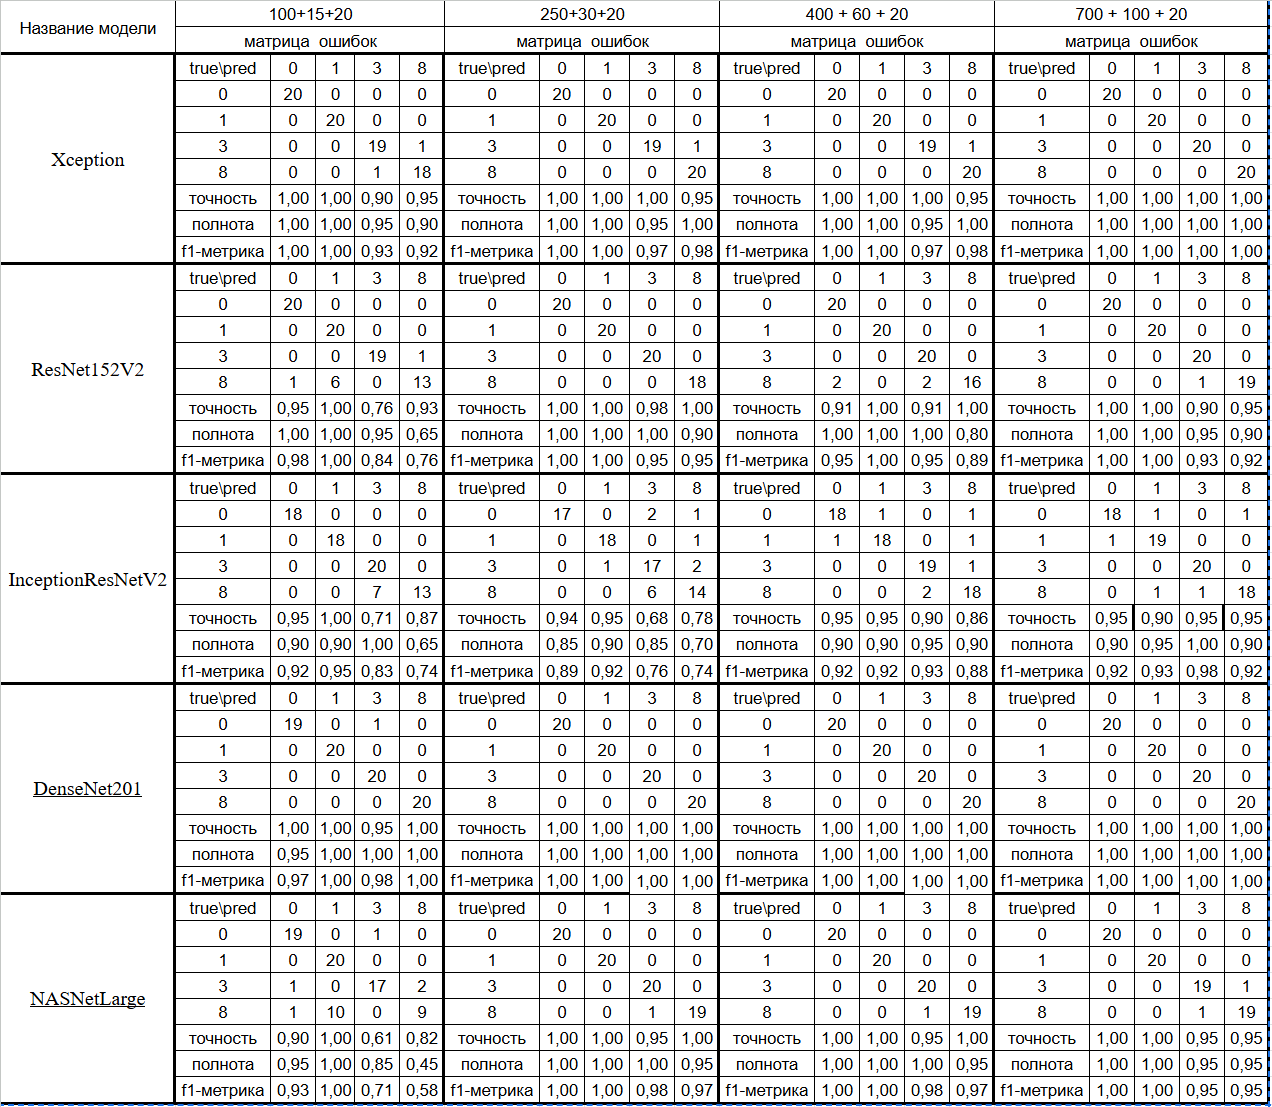